In [154]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PART 1: WRANGLING

## Problem 1

In [155]:
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query from Salaries and Teams tables
sal_query = "SELECT teamID, yearID, sum(salary) as total_payroll, sum(salary)/count(salary) as payroll_mean FROM Salaries GROUP BY teamID, yearID"
team_query = "SELECT (W*100.0/G) as win_percentage, * FROM Teams GROUP BY teamID, yearID"
mean_query = "SELECT yearID, sum(salary)/count(salary) as sal_mean FROM Salaries GROUP BY yearID"

# Gather information from queries
sal_tbl = pd.read_sql(sal_query, conn)
team_tbl = pd.read_sql(team_query, conn)
mean_tbl = pd.read_sql(mean_query, conn)

# Merge tables into Dataframe
res_tbl = pd.merge(sal_tbl, team_tbl, how='inner', on=['teamID', 'yearID'])
res_tbl = pd.merge(res_tbl, mean_tbl, how='inner', on=['yearID'])

res_tbl = res_tbl[['teamID', 'yearID', 'total_payroll', 'payroll_mean', 'win_percentage', 'sal_mean']]

res_tbl

,teamID,yearID,total_payroll,payroll_mean,win_percentage,sal_mean
0,ATL,1985,14807000.0,6.730455e+05,40.740741,4.762994e+05
1,BAL,1985,11560712.0,5.254869e+05,51.552795,4.762994e+05
2,BOS,1985,10897560.0,4.359024e+05,49.693252,4.762994e+05
3,CAL,1985,14427894.0,5.152819e+05,55.555556,4.762994e+05
4,CHA,1985,9846178.0,4.688656e+05,52.147239,4.762994e+05
...,...,...,...,...,...,...
853,SLN,2014,120693000.0,4.310464e+06,55.555556,3.980446e+06
854,TBA,2014,72689100.0,2.907564e+06,47.530864,3.980446e+06
855,TEX,2014,112255059.0,4.677294e+06,41.358025,3.980446e+06
856,TOR,2014,109920100.0,4.396804e+06,51.234568,3.980446e+06


# PART 2: EXPLORATORY DATA ANALYSIS

## Payroll Distribution: Problem 2

Text(0, 0.5, 'Total Payroll (in billions)')

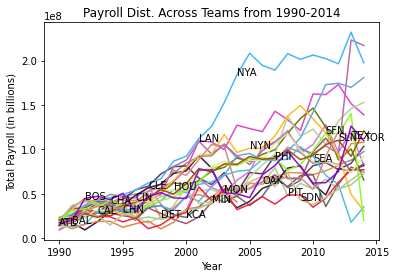

In [158]:
# Sort values by yearID
res_tbl.sort_values('yearID', ascending=True)
temp1 = res_tbl[res_tbl['yearID'] >= 1990]
temp1 = temp1[temp1['yearID'] <= 2014]

# Remove duplicate rows
teams = temp1['teamID'].drop_duplicates()
temp1 = temp1[['yearID', 'teamID', 'total_payroll']]
temp1 = temp1.set_index('teamID')

# Plot payroll dist. for each team in dataframe
year = 1990
for team in teams:
    temp2 = temp1.loc[lambda temp1: temp1.yearID == year, :]
    if team in temp2.index:
        num = temp2.loc[team, 'total_payroll']
        plt.annotate(team, xy = (year, num))
        plt.plot(temp1.loc[team, 'yearID'], temp1.loc[team, 'total_payroll'], color=np.random.rand(3,))
        if (year < 2014):
            year += 1
        else:
            year = 1990

plt.title('Payroll Dist. Across Teams from 1990-2014')
plt.xlabel('Year')
plt.ylabel('Total Payroll (in billions)')

### Question 1

One observation that can be made is that as time progresses, the payroll distribution for each team seems to increase at a gradual rate (some teams are exceptions). Another observation is that as time progresses, the spread of the
payroll distribution seems to increase as well. In other words, as time goes on, there is a larger and larger discrepancy between each teams distribution compared to the others.

## Payroll Distribution: Problem 3

Text(0, 0.5, 'Total mean payroll (in millions)')

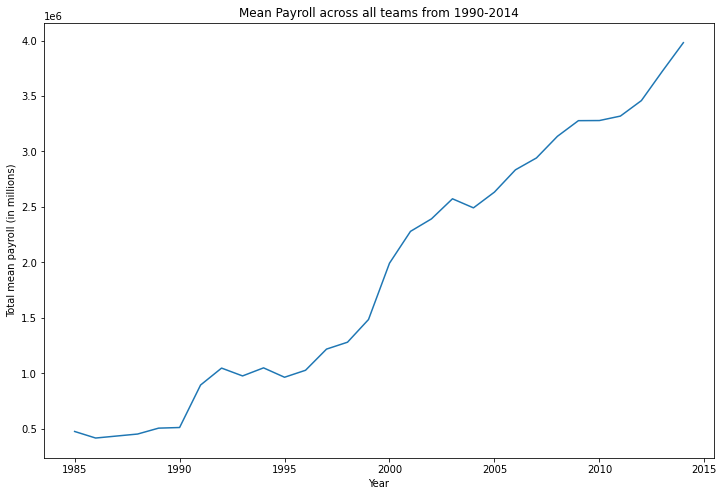

In [160]:
# Sort by values by increasing mean salary
res_tbl.sort_values('sal_mean', ascending = True)

# Create plot for mean payroll over time
plt.figure(figsize=(12,8))
plt.plot(res_tbl['yearID'], res_tbl['sal_mean'])
plt.title('Mean Payroll across all teams from 1990-2014')
plt.xlabel('Year')
plt.ylabel('Total mean payroll (in millions)')

## Correlation between payroll and winning percentage: Problem 4

In [163]:
# Create bins and labels for 'periods' column
bins = [1989, 1994, 1999, 2004, 2009, 2014]
periods = ['1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']

# Copy resultant table from previous part for use in this problem
res_tbl2 = res_tbl.copy()

# Create 'periods' column
res_tbl2['periods'] = pd.cut(res_tbl2['yearID'], bins, labels=periods)

# Copy this resultant table for later use in Problem 5
res_tbl3 = res_tbl2.copy()

# Group rows by their time periods
res_tbl2 = res_tbl2.groupby('periods')

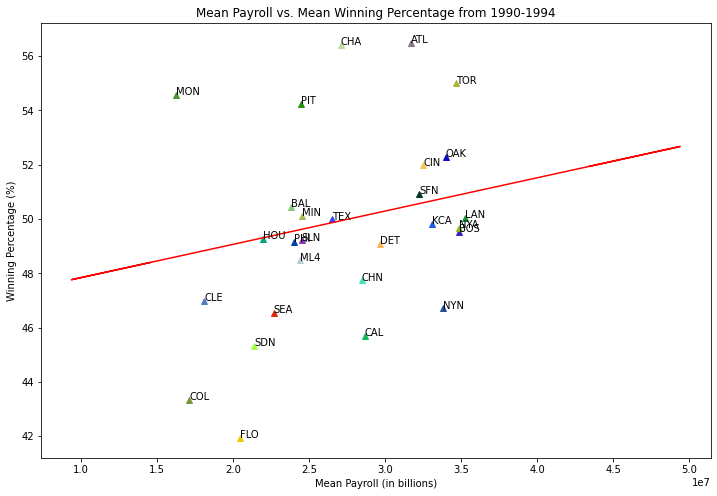

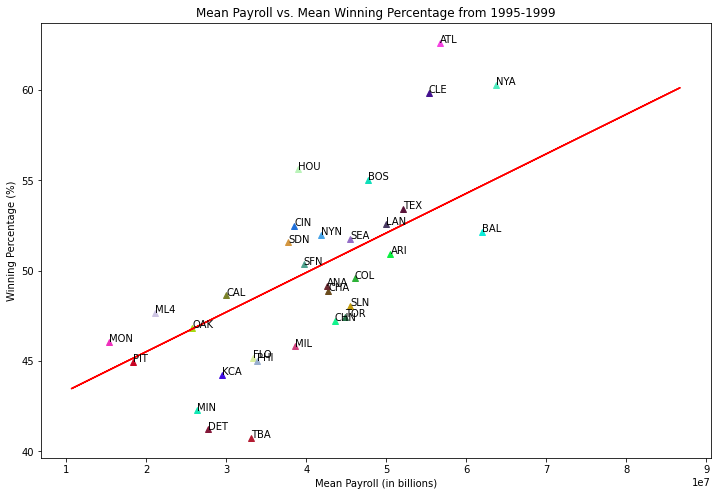

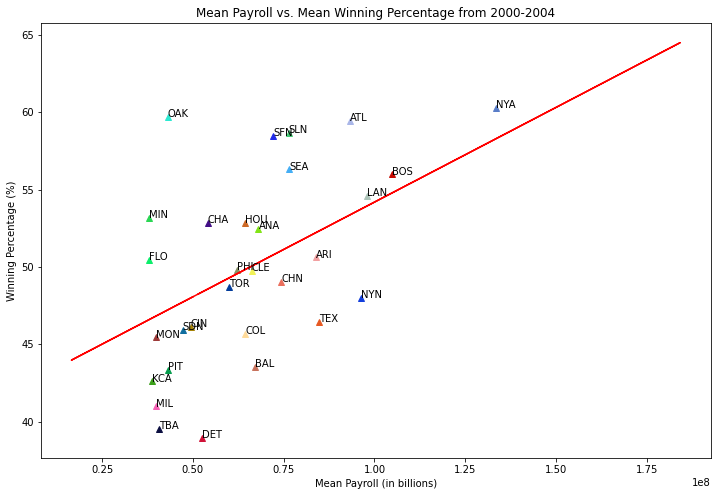

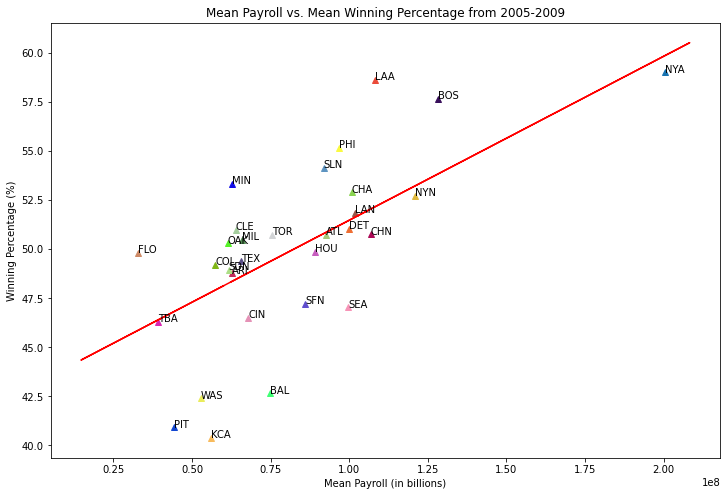

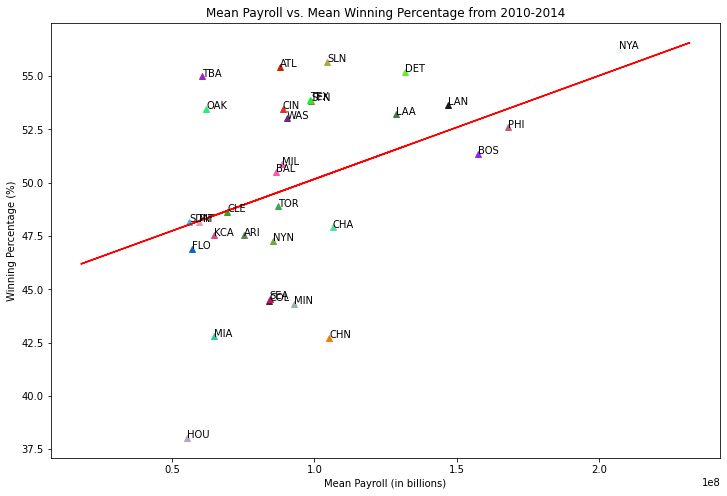

In [164]:
# Create the five payroll vs. winning percentage plots
for period in periods:
    plt.figure(figsize=(12,8))
    p = res_tbl2.get_group(period)
    temp = p[['teamID', 'total_payroll', 'win_percentage']]
    temp = temp.set_index('teamID')
    teams = p['teamID'].drop_duplicates()
    
    for team in teams:
        x_plot = temp.loc[team, 'total_payroll'].mean()
        y_plot = temp.loc[team, 'win_percentage'].mean()
        
        plt.plot(x_plot, y_plot, '^', color=np.random.rand(3,))
        plt.annotate(team, xy=(x_plot, y_plot))
    
    # Create linear regression line for each plot
    x_plot = p['total_payroll']
    y_plot = p['win_percentage']
    m, b = np.polyfit(x_plot, y_plot, 1)
    plt.plot(x_plot, m * x_plot + b, color='r')
    
    plt.title('Mean Payroll vs. Mean Winning Percentage from ' + period)
    plt.xlabel('Mean Payroll (in billions)')
    plt.ylabel('Winning Percentage (%)')

### Question 2

There is a clear trend shown, which is that the higher the mean payroll for a team, the higher their winning percentage. Teams like the New York Yankees (NYA) have a history of spending a very large amount of money over the years, and yet, compared to other teams that spend a lot less, their winning percentage is actually quite similar. For example, the Oakland A's (OAK) have a history of spending less than most teams throughout the years, yet have maintained a surprisingly high winning percentage. The have proved to have a high spending efficiency (based on the fact that their datapoint is plotted above the regression line for most time periods between 1990-2014).

# PART 3: DATA TRANSFORMATIONS

## Standardizing Across Years: Problem 5

In [165]:
# Calculate mean payroll for each year
payroll_mean = (res_tbl3.groupby(['yearID']))['total_payroll'].mean()
payroll_mean = payroll_mean.to_frame()
payroll_mean = payroll_mean.rename(columns={'total_payroll':'avg_payroll'})

# Calculate standard deviation payroll for each year
payroll_std = (res_tbl3.groupby(['yearID']))['total_payroll'].std()
payroll_std = payroll_std.to_frame()
payroll_std = payroll_std.rename(columns={'total_payroll':'std_payroll'})

# Merge dataframes by year and reset tables
avg_tbl = payroll_mean.merge(payroll_std, how='inner', left_on=['yearID'], right_on=['yearID'])
avg_tbl = avg_tbl.reset_index()

# Create dataframe and setting standardized payroll as 0
standardized_pr = res_tbl3.copy()
standardized_pr['std_payroll'] = 0.0

# Iterate through each dataframe
# If the years match, caluclate the standardized payroll and add it to the standardized_pr dataframe
for i, row1 in  standardized_pr.iterrows():
    for j, row2 in avg_tbl.iterrows():
        if row1['yearID'] == row2['yearID']:
            avg_payroll_j = avg_tbl['avg_payroll'][j]
            std_j = avg_tbl['std_payroll'][j]
            std_payroll_ij = (standardized_pr['total_payroll'][i] - avg_payroll_j) / std_j
            standardized_pr.at[i, 'std_payroll'] = std_payroll_ij

# Cleaning data (getting rid of NaN values, etc.)
standardizd_pr = standardized_pr.sort_values(by=['yearID', 'teamID'])
standardized_pr = standardized_pr.dropna().reset_index()
standardized_pr = standardized_pr.drop(columns=['index', 'payroll_mean', 'sal_mean'])

standardized_pr

,teamID,yearID,total_payroll,win_percentage,periods,std_payroll
0,ATL,1990,14555501.0,40.123457,1990-1994,-0.667275
1,BAL,1990,9680084.0,47.204969,1990-1994,-1.959861
2,BOS,1990,20558333.0,54.320988,1990-1994,0.924213
3,CAL,1990,21720000.0,49.382716,1990-1994,1.232198
4,CHA,1990,9491500.0,58.024691,1990-1994,-2.009859
...,...,...,...,...,...,...
723,SLN,2014,120693000.0,55.555556,2010-2014,0.457126
724,TBA,2014,72689100.0,47.530864,2010-2014,-0.593171
725,TEX,2014,112255059.0,41.358025,2010-2014,0.272509
726,TOR,2014,109920100.0,51.234568,2010-2014,0.221422


## Standardizing Across Years: Problem 6

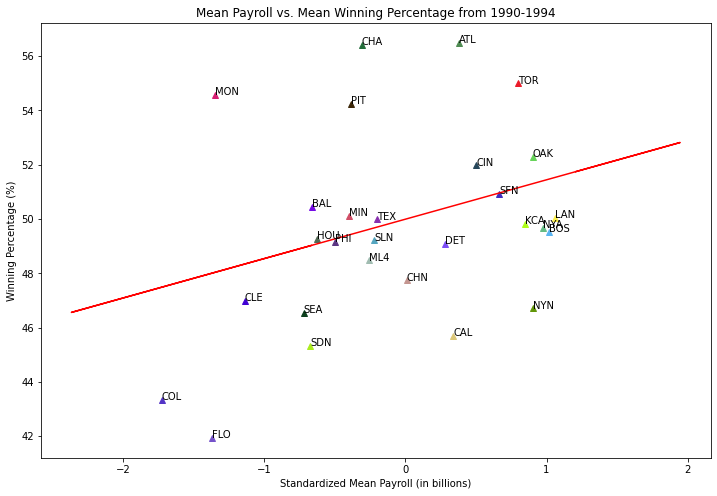

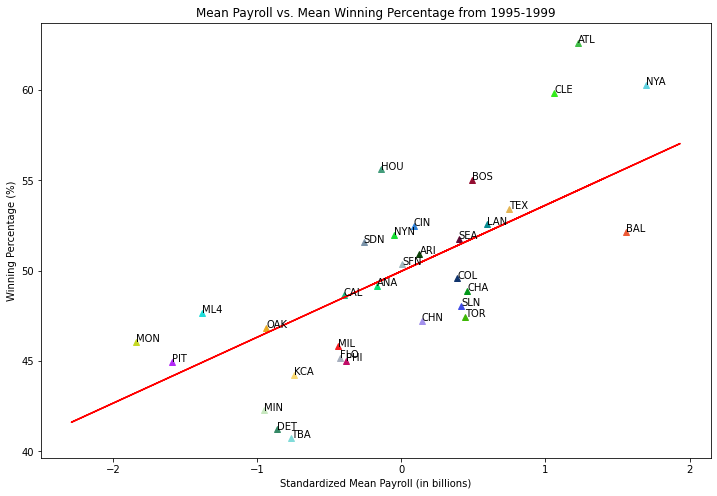

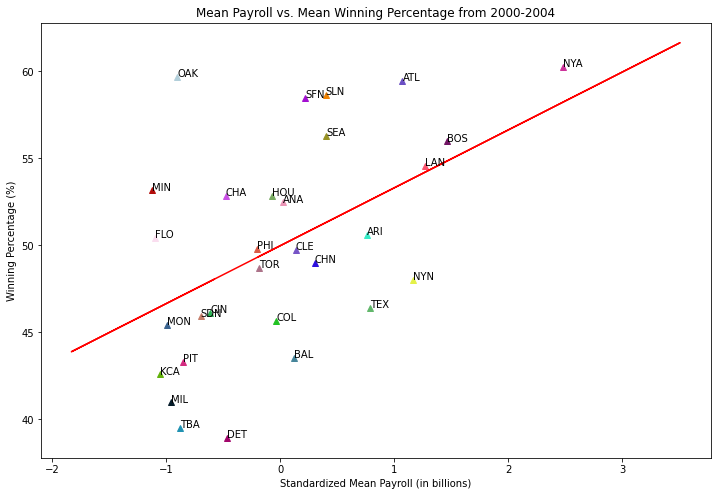

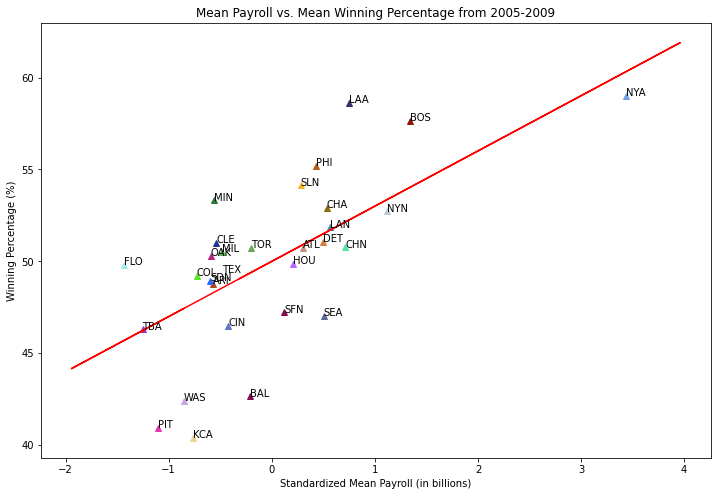

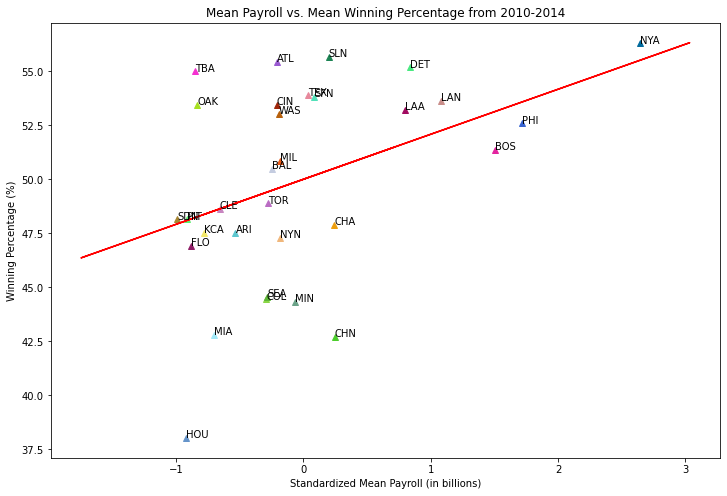

In [166]:
# Group new dataframe by time period
res_tbl4 = standardized_pr.groupby('periods')

# Create five plot for standardized payroll vs. winning percentage
for period in periods:
    plt.figure(figsize=(12,8))
    p = res_tbl4.get_group(period)
    temp = p[['teamID', 'std_payroll', 'win_percentage']]
    temp = temp.set_index('teamID')
    teams = p['teamID'].drop_duplicates()
    
    for team in teams:
        x_plot = temp.loc[team, 'std_payroll'].mean()
        y_plot = temp.loc[team, 'win_percentage'].mean()
        
        plt.plot(x_plot, y_plot, '^', color=np.random.rand(3,))
        plt.annotate(team, xy=(x_plot, y_plot))
        
    x_plot = p['std_payroll']
    y_plot = p['win_percentage']
    m, b = np.polyfit(x_plot, y_plot, 1)
    plt.plot(x_plot, m * x_plot + b, color='r')
    
    plt.title('Mean Payroll vs. Mean Winning Percentage from ' + period)
    plt.xlabel('Standardized Mean Payroll (in billions)')
    plt.ylabel('Winning Percentage (%)')

### Question 3

Both sets of plots are almost exactly the same, except for the fact the the x-axis from the Problem 4 plots are scaled on the unstandardized mean payroll, while the x-axis from the Problem 6 plots are scaled on the standardized mean payroll. Becasue of this, the Problem 6 plots contain some negative values for the payroll, while the Problem 4 plots contain all positive values. Because of the "unstandardization" of the mean payroll for the Problem 4 plots, it is difficult to compare them against each other. The plots from Problem 6, however, are much easier to compare because we can now see how many standard deviations each team's payroll is from the mean payroll.

## Expected Wins: Problem 7

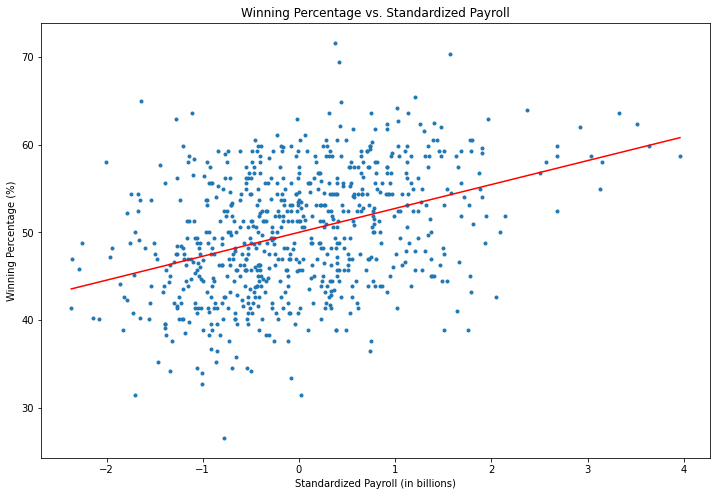

In [167]:
# Create copy of standardized_pr dataframe
res_tbl5 = standardized_pr.copy()

# Get x and y coordinates
x_plot = res_tbl5['std_payroll']
y_plot = res_tbl5['win_percentage']

# Find slope and intercept, as well as data points
m, b = np.polyfit(x_plot, y_plot, 1)
datapts = np.linspace(x_plot.min(), x_plot.max(), 100)

# Create scatterplot of winning percentage vs. standardized payroll and plotting regression line
plt.figure(figsize=(12,8))
plt.title('Winning Percentage vs. Standardized Payroll')
plt.xlabel('Standardized Payroll (in billions)')
plt.ylabel('Winning Percentage (%)')
plt.plot(x_plot, y_plot, '.')
plt.plot(datapts, m * datapts + b, color='r')

## Spending Efficiency: Problem 8

Text(0, 0.5, 'Spending Efficiency (%)')

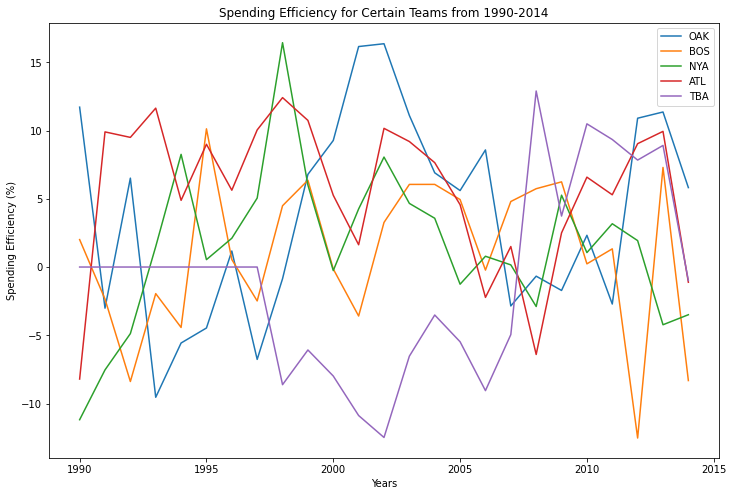

In [168]:
# Calculate spending efficiency for each time period
standardized_pr['expected_win'] = 50 + 2.5 * standardized_pr['std_payroll']
standardized_pr['efficiency'] = standardized_pr['win_percentage'] - standardized_pr['expected_win']

# List of teams used in plot
teams = ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']

# Create new dataframe
res_tbl6 = standardized_pr.sort_values('yearID')
res_tbl6 = res_tbl6[['teamID', 'yearID', 'efficiency']]

# Iterate through teams to see if they play during each year
# If not, they are added to dataframe with spending efficiency of zero
for team in teams:
    temp = res_tbl6.set_index('teamID')
    temp = temp.loc[team, :]
    for year in range(1990, 2015):
        if year not in temp.values:
            res_tbl6.loc[len(res_tbl6.index)] = [team, year, 0.0]
            
res_tbl6 = res_tbl6.sort_values('yearID')
res_tbl6 = res_tbl6.set_index('teamID')

plt.figure(figsize=(12,8))

# Plot each team's spending efficency
for team in teams:
    x_plot = res_tbl6.loc[team, 'yearID']
    y_plot = res_tbl6.loc[team, 'efficiency']
    plt.plot(x_plot, y_plot, label=team)
    plt.legend(bbox_to_anchor=(1,1))
    
plt.title('Spending Efficiency for Certain Teams from 1990-2014')
plt.xlabel('Years')
plt.ylabel('Spending Efficiency (%)')

### Question4

This plot shows that the Oakland A's (OAK) spending efficiency is not as high as previous plots led us to believe. They did have the best spending efficiency during the years of 2000-2003 (which is the famous "Moneyball" period), but eventually their spending efficiency began to follow the same trends as the other teams on our plot. The efficiencies in our plot are highly volatile, fluctuating greatly over the years, which is probably due to the way we define "spending efficiency" in this project. There are other potential variables that might affect spending efficiency that we did not look at during this project, such as how long it takes money to actually impact the winning percentage, or the specific impact money has on any one team. During the A's "Moneyball" period, their team spending efficiency was around 18%. Of the other five teams we chose to use in the plot, the Atlanta Braves (ATL) were the closest to the A's in terms of efficiency, and yet, they were still about 6% lower than Oakland in terms of efficiency.